In [1]:
import os

os.chdir("./..")

In [2]:
os.getcwd()

'd:\\jupyter-yoon\\git-repo-tmp\\Yet-Another-EfficientDet-Pytorch'

In [6]:
# test. 1 epoch
! python mytrain.py -c 0 -p fashion --data_path ../../data/ --head_only True --lr 5e-3 --batch_size 32 --load_weights weights/efficientdet-d0.pth  --num_epochs 1 --save_interval 100

loading annotations into memory...
Done (t=7.85s)
creating index...
index created!
loading annotations into memory...
Done (t=0.87s)
creating index...
index created!
[Warning] Ignoring Error(s) in loading state_dict for EfficientDetBackbone:
	size mismatch for classifier.header.pointwise_conv.conv.weight: copying a param with shape torch.Size([18, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([414, 64, 1, 1]).
	size mismatch for classifier.header.pointwise_conv.conv.bias: copying a param with shape torch.Size([18]) from checkpoint, the shape in current model is torch.Size([414]).
[Warning] Don't panic if you see this, this might be because you load a pretrained weights with different number of classes. The rest of the weights should be loaded already.
[Info] loaded weights: efficientdet-d0.pth, resuming checkpoint from step: 0
[Info] freezed backbone
checkpoint...
checkpoint...
checkpoint...
checkpoint...
checkpoint...
checkpoint...
checkpoint...
checkpoint...
ch


  0%|          | 0/1425 [00:00<?, ?it/s]
Step: 0. Epoch: 0/1. Iteration: 1/1425. Cls loss: 14405.33008. Reg loss: 8.83832. Total loss: 14414.16797:   0%|          | 0/1425 [01:30<?, ?it/s]
Step: 0. Epoch: 0/1. Iteration: 1/1425. Cls loss: 14405.33008. Reg loss: 8.83832. Total loss: 14414.16797:   0%|          | 1/1425 [01:30<35:47:48, 90.50s/it]
Step: 1. Epoch: 0/1. Iteration: 2/1425. Cls loss: 10282.01465. Reg loss: 7.43373. Total loss: 10289.44824:   0%|          | 1/1425 [01:32<35:47:48, 90.50s/it]
Step: 1. Epoch: 0/1. Iteration: 2/1425. Cls loss: 10282.01465. Reg loss: 7.43373. Total loss: 10289.44824:   0%|          | 2/1425 [01:32<15:06:38, 38.23s/it]
Step: 2. Epoch: 0/1. Iteration: 3/1425. Cls loss: 5999.81738. Reg loss: 6.04273. Total loss: 6005.86035:   0%|          | 2/1425 [01:34<15:06:38, 38.23s/it]  
Step: 2. Epoch: 0/1. Iteration: 3/1425. Cls loss: 5999.81738. Reg loss: 6.04273. Total loss: 6005.86035:   0%|          | 3/1425 [01:34<8:37:48, 21.85s/it] 
Step: 3. Epoch: 0

In [9]:
%cd logs/fashionpedia
weight_file = !ls -Art | grep efficientdet
%cd ../..

#uncomment the next line to specify a weight file
#weight_file[-1] = 'efficientdet-d0_49_1400.pth'

! python coco_eval.py -c 0 -p birdview_vehicles -w "logs/fashionpedia/efficientdet-d0_0_1400.pth"

d:\jupyter-yoon\git-repo-tmp\Yet-Another-EfficientDet-Pytorch\logs\fashionpedia
d:\jupyter-yoon\git-repo-tmp\Yet-Another-EfficientDet-Pytorch
running coco-style evaluation on project birdview_vehicles, weights logs/fashionpedia/efficientdet-d0_0_1400.pth...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Traceback (most recent call last):
  File "d:\jupyter-yoon\git-repo-tmp\Yet-Another-EfficientDet-Pytorch\coco_eval.py", line 149, in <module>
    model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
  File "c:\Python39\lib\site-packages\torch\nn\modules\module.py", line 2041, in load_state_dict
    raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
RuntimeError: Error(s) in loading state_dict for EfficientDetBackbone:
	size mismatch for classifier.header.pointwise_conv.conv.weight: copying a param with shape torch.Size([414, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([18, 64, 1, 1]).
	size mismatch for classifier.header.pointwise_conv.conv.bias: copying a param with shape torch.Size([414]) from checkpoint, the shape in current model is torch.Size([18]).


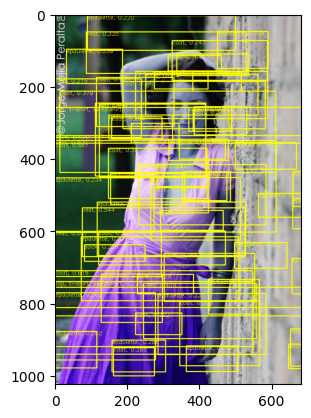

In [13]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

compound_coef = 0
force_input_size = None  # set None to use default size
img_path = '../../data/fashionpedia/test2020/00e45dd233e31906f538ba17dd45bf29.jpg'

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = [
  'shirt, blouse',
  'top, t-shirt, sweatshirt',
  'sweater',
  'cardigan',
  'jacket',
  'vest',
  'pants',
  'shorts',
  'skirt',
  'coat',
  'dress',
  'jumpsuit',
  'cape',
  'glasses',
  'hat',
  'headband, head covering, hair accessory',
  'tie',
  'glove',
  'watch',
  'belt',
  'leg warmer',
  'tights, stockings',
  'sock',
  'shoe',
  'bag, wallet',
  'scarf',
  'umbrella',
  'hood',
  'collar',
  'lapel',
  'epaulette',
  'sleeve',
  'pocket',
  'neckline',
  'buckle',
  'zipper',
  'applique',
  'bead',
  'bow',
  'flower',
  'fringe',
  'ribbon',
  'rivet',
  'ruffle',
  'sequin',
  'tassel'
  ]

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(0.7, 1.4), (1.0, 1.0), (1.5, 0.7)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

model.load_state_dict(torch.load('logs/fashionpedia/efficientdet-d0_0_1400.pth'))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

out = invert_affine(framed_metas, out)

for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

        plt.imshow(ori_imgs[i])

